In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat
import uncertainties
import os
from scipy.interpolate import interp1d
from dataclasses import dataclass
from typing import List, Tuple
from tqdm.notebook import tqdm
%matplotlib widget

## Electron yield

We first simulate the measurement setup with different electron yields. Hereby we use the "nominal" position of the source, sample and PMT. Afterwards we will look at systematics.
The photon number $N$ produced by the sample increases linearly with the electron yield $y$, $N = y\cdot E_{deposited} + C$, where $C$ is the Cherenkov light contribution.

In [3]:
N_simulated = 1000000
yields = np.arange(0,320,20)

In [ ]:
%%capture
for electron_yield in yields:
    os.system(f"./OMSim_scintillation_yield --QE_file qe_PMT373.txt --threads 31 -n {N_simulated} --detector_type 0 --yield_alphas 0 --yield_electrons {electron_yield} --output_file electron_simu/{electron_yield}")

In [2]:
PE_THRESHOLD = 0.2
MIN_DIFF_TIME = 20 

@dataclass
class Measurement:
    rate_sample : ufloat
    rate_background : ufloat
    temperature : float
    threshold: ufloat
    @property
    def rate(self):
        return self.rate_sample-self.rate_background
        
class Pulses:
    def __init__(self, initial_capacity=1000):
        self.probabilities = np.zeros(initial_capacity, dtype=np.float64)
        self.charges = np.zeros(initial_capacity, dtype=np.float64)
        self.size = 0
        
    def append(self, charge: float, probability: float) -> None:
        if self.size == len(self.charges):
            self._expand()
        self.charges[self.size] = charge
        self.probabilities[self.size] = min(probability, 1.0)
        self.size += 1
        
    def _expand(self):
        new_capacity = len(self.charges) * 2
        self.charges = np.resize(self.charges, new_capacity)
        self.probabilities = np.resize(self.probabilities, new_capacity)
        
    def count_detected(self, threshold: float) -> Tuple[float, int]:
        mask = self.charges[:self.size] >= threshold
        weights_over_threshold = self.probabilities[:self.size][mask]
        return np.sum(weights_over_threshold), np.sum(mask)

    def __len__(self):
        return self.size

@dataclass
class SimulationData:
    event_nr: np.ndarray
    hit_time: np.ndarray
    energy: np.ndarray
    charge: np.ndarray
    transit_time: np.ndarray
    detection_probability: np.ndarray
        
    def process_data(self, N) -> None:
        self.N_simulated = N
        self.pulses = Pulses()
        
        # Sort all data by event_nr and then by hit_time
        sort_indices = np.lexsort((self.hit_time, self.event_nr))
        self.event_nr = self.event_nr[sort_indices]
        self.hit_time = self.hit_time[sort_indices]
        self.energy = self.energy[sort_indices]
        self.charge = self.charge[sort_indices]
        self.transit_time = self.transit_time[sort_indices]
        self.detection_probability = self.detection_probability[sort_indices]
        
        self.detection_time = self.hit_time * 1e9 + self.transit_time
        
        # Find the boundaries between events
        event_boundaries = np.where(np.diff(self.event_nr) != 0)[0] + 1
        event_boundaries = np.concatenate(([0], event_boundaries, [len(self.event_nr)]))
        
        for start, end in zip(event_boundaries[:-1], event_boundaries[1:]):
            self.check_SPE_MPE(self.detection_time[start:end], self.charge[start:end], self.detection_probability[start:end])

    
    def check_SPE_MPE(self, times: np.ndarray, charges: np.ndarray, DEs: np.ndarray) -> None:
        if len(times) == 1:
            self.pulses.append(charges[0], DEs[0])
            return
        
        time_diffs = np.diff(times)
        split_indices = np.where(time_diffs > MIN_DIFF_TIME)[0] + 1
        split_indices = np.concatenate(([0], split_indices, [len(times)]))
        
        cum_charges = np.add.reduceat(charges, split_indices[:-1])
        cum_des = np.add.reduceat(DEs, split_indices[:-1])
        
        for charge, de in zip(cum_charges, cum_des):
            self.pulses.append(charge, de)
        
    def hits_per_decay(self, pe_threshold: float = PE_THRESHOLD) -> ufloat:
        hits_detected, total_counts = self.pulses.count_detected(pe_threshold)
        rel_error = np.sqrt(total_counts) / total_counts if total_counts > 0 else 0
        detected_per_decay = hits_detected / self.N_simulated
        return ufloat(detected_per_decay, detected_per_decay * rel_error)

In [6]:
analysed_data = {}
for electron_yield in tqdm(yields):
    analysed_data[electron_yield] = SimulationData(*np.loadtxt(f"electron_simu/{electron_yield}_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    analysed_data[electron_yield].process_data(N_simulated)

  0%|          | 0/16 [00:00<?, ?it/s]

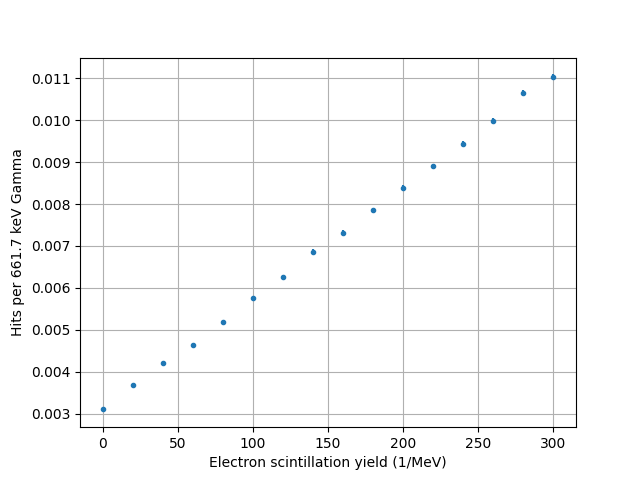

In [7]:

ufloat_values = [analysed_data[yield_val].hits_per_decay() for yield_val in yields]

yields = np.array(yields)
ufloat_values = np.array(ufloat_values)

plt.figure()
plt.errorbar(yields, [val.n for val in ufloat_values], yerr=[val.s for val in ufloat_values], fmt='.')
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.ylabel('Hits per 661.7 keV Gamma')
plt.grid()
plt.show()

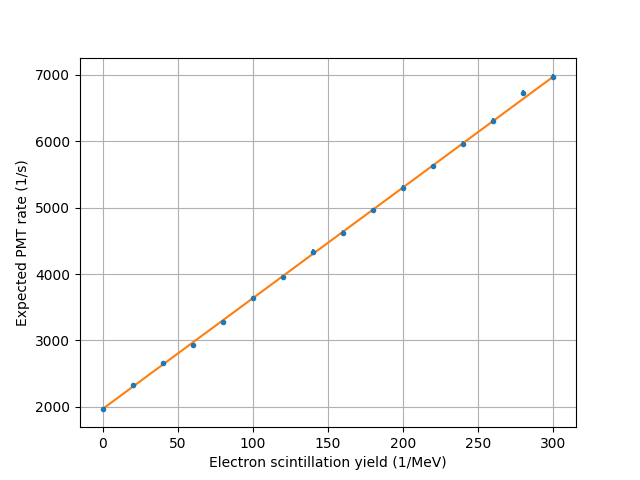

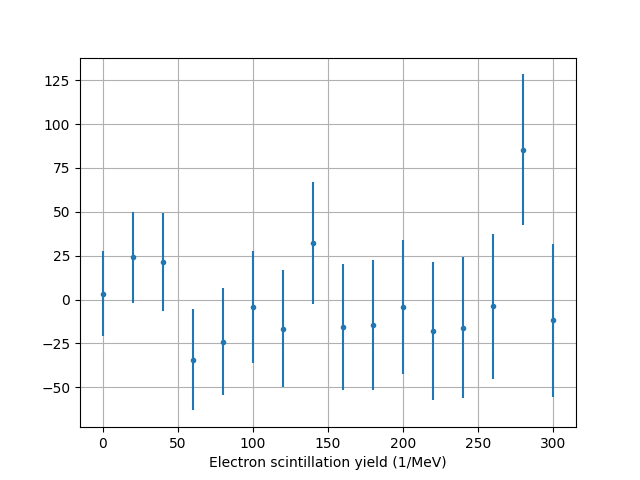

In [8]:
def lin(x,a,b):
    return x*a+b

CS137_activity = ufloat(631872, 11760)
pmt_rate = np.array(ufloat_values)*CS137_activity.n

popt,pcov = curve_fit(lin,yields, [val.n for val in pmt_rate], sigma=[val.s for val in pmt_rate], absolute_sigma=1 )
sim_slope, sim_const = uncertainties.correlated_values(popt, pcov)

plt.figure()
plt.errorbar(yields, [val.n for val in pmt_rate], yerr=[val.s for val in pmt_rate], fmt='.')
plt.plot(yields, lin(yields, *popt))
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.ylabel('Expected PMT rate (1/s)')
plt.grid()
plt.show()

plt.figure()
plt.errorbar(yields, np.array([val.n for val in pmt_rate])-lin(yields, *popt), yerr=[val.s for val in pmt_rate], fmt='.')
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.grid()
plt.show()

In [9]:

    
measured_data = {}        
with open("analysed_data_Okamot_Cs137_with_sample_AF_corrected.dat", "r") as f:
    for line in f:
        if "#" in line:
            continue
        temperature, _, _, rate, rate_err, _ = np.array(line.split()).astype("float")
        measured_data[temperature] = Measurement(ufloat(rate, rate_err), ufloat(rate, rate_err), temperature, ufloat(0.3, 0.01))
with open("analysed_data_Okamot_Cs137_background_AF_corrected.dat", "r") as f:
    for line in f:
        if "#" in line:
            continue
        temperature, _, _, rate, rate_err, _ = np.array(line.split()).astype("float")
        measured_data[temperature].rate_background= ufloat(rate, rate_err)
        
print(measured_data)

{np.float64(-50.0): Measurement(rate_sample=13976.595926508071+/-56.88709056621227, rate_background=7280.899660863023+/-8.536720547928988, temperature=np.float64(-50.0), threshold=0.3+/-0.01), np.float64(-40.0): Measurement(rate_sample=12701.66012394726+/-9.839563945953968, rate_background=6582.347322274894+/-12.464648864509243, temperature=np.float64(-40.0), threshold=0.3+/-0.01), np.float64(-30.0): Measurement(rate_sample=11586.45911308943+/-8.213513220602552, rate_background=5969.103817805766+/-7.962381416541651, temperature=np.float64(-30.0), threshold=0.3+/-0.01), np.float64(-25.0): Measurement(rate_sample=11085.169887643418+/-8.787610770089865, rate_background=5643.250815976784+/-10.637283034372665, temperature=np.float64(-25.0), threshold=0.3+/-0.01), np.float64(-20.0): Measurement(rate_sample=10596.967517102095+/-7.420854676135321, rate_background=5336.468083510155+/-12.668607840529997, temperature=np.float64(-20.0), threshold=0.3+/-0.01), np.float64(-15.0): Measurement(rate_sa

In [10]:
def get_yield(obj, rates):
    popt,pcov = curve_fit(lin,yields, [val.n for val in rates], sigma=[val.s for val in rates], absolute_sigma=1 )
    sim_slope, sim_const = uncertainties.correlated_values(popt, pcov)
    e_yield = (obj.rate-sim_const)/sim_slope
    return e_yield

def get_yield_with_systematics(obj: Measurement):
    baseline_rates = [CS137_activity.n*analysed_data[yield_val].hits_per_decay(obj.threshold.n) for yield_val in yields]
    baseline_yield = get_yield(obj, baseline_rates)
    print(f"Yield: {baseline_yield}")
    #Sys uncertainty from threshold
    yield_sys = []
    for pe_threshold in np.random.normal(obj.threshold.n, obj.threshold.s, 1000):
        rates = [CS137_activity*analysed_data[yield_val].hits_per_decay(pe_threshold) for yield_val in yields]
        yield_sys.append(get_yield(obj, rates).n)
    sys_pe = np.std(yield_sys)
        
    #Sys uncertainty from source activity
    rates = [CS137_activity*analysed_data[yield_val].hits_per_decay(obj.threshold.n) for yield_val in yields]
    sys_activity_yield = get_yield(obj, rates).s
    
    print(f"Systematic error from source activity {sys_activity_yield} and PE threshold {sys_pe} (1/MeV)")
    
    return baseline_yield, np.sqrt(sys_activity_yield**2+sys_pe**2)

In [11]:
for key, obj in measured_data.items():
    e_yields, u_sys = get_yield_with_systematics(obj)
    obj.calculated_yield = e_yields
    obj.yield_systematic_error = u_sys
    

Yield: 287+/-4
Systematic error from source activity 4.5807634776121775 and PE threshold 0.5480058166577327 (1/MeV)
Yield: 252.5+/-1.3
Systematic error from source activity 2.70426689010335 and PE threshold 0.49196848308122415 (1/MeV)
Yield: 222.1+/-1.0
Systematic error from source activity 2.2708805387862387 and PE threshold 0.42655639915311705 (1/MeV)
Yield: 211.5+/-1.1
Systematic error from source activity 2.2049077468605334 and PE threshold 0.4366800467533793 (1/MeV)
Yield: 200.5+/-1.1
Systematic error from source activity 2.1135216607767537 and PE threshold 0.41453638353903666 (1/MeV)
Yield: 187.5+/-1.0
Systematic error from source activity 1.9158459923568045 and PE threshold 0.39502069278715934 (1/MeV)
Yield: 176.3+/-1.0
Systematic error from source activity 1.8222293050403096 and PE threshold 0.39595731940535406 (1/MeV)
Yield: 166.3+/-0.9
Systematic error from source activity 1.7192912359223766 and PE threshold 0.3625875788099266 (1/MeV)


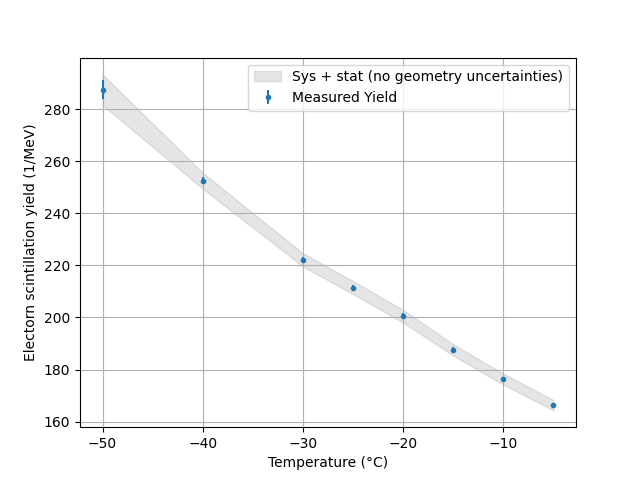

In [12]:
temperatures = np.array(list(measured_data.keys()))
yields = np.array([measured_data[temp].calculated_yield.nominal_value for temp in temperatures])
yields_err = np.array([measured_data[temp].calculated_yield.std_dev for temp in temperatures])
sys_err = np.array([measured_data[temp].yield_systematic_error for temp in temperatures])
sys_err = np.sqrt(sys_err*sys_err + yields_err*yields_err)
plt.figure()
# Plotting
plt.errorbar(temperatures, yields, yerr=yields_err, fmt='.', label='Measured Yield')
plt.fill_between(temperatures, yields - sys_err, yields + sys_err, color='gray', alpha=0.2, label='Sys + stat (no geometry uncertainties)')

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Electorn scintillation yield (1/MeV)')
plt.grid()
plt.legend()

# Show pl

To estimate the systematic uncertainty, we assume that the ratio of emitted Cherenkov $C$ to emitted scintillation light for a given electron yield $y$, $S(y) = y\cdot E_{deposited}$ is independent of position variations of the different components in the setup. This would mean that in a setup where we have less deposited energy (because for example the source if further away from the sample), the relative Cherenkov light intensity will reduce the same amount. This is obviously not true, but probably ok, as the setup geometry variations are small. Under this assumption, the total number of hits on PMT will be a $\epsilon \cdot (C+S)$, where $\epsilon$ is a geometry factor. 

Now, we simulate the setup varying all positions with their respective uncertainties at the average yield. 

In [ ]:
average_yield = np.mean(yields)
N_simulated = 1000000
hits_per_decay = []
for n in tqdm(range(500)):
    os.system(f"./OMSim_scintillation_yield --QE_file qe_PMT373.txt --threads 31 -n {N_simulated} --detector_type 0 --yield_alphas 0 --yield_electrons {average_yield} --output_file tmp --systematics")
    tmp = SimulationData(*np.loadtxt(f"tmp_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    tmp.process_data(N_simulated)
    hits_per_decay.append(tmp.hits_per_decay())
    os.system("rm -rf tmp_*.dat")
    os.system("rm -rf tmp_*.json")

In [14]:
hitrate = [val.n for val in hits_per_decay]
hitratest = [val.s for val in hits_per_decay]
print(np.std(hitrate)*100/np.mean(hitrate), np.mean(hitratest)*100/np.mean(hitrate))

1.4441145358501128 0.7056488754113044


In [15]:
rel_sys_stat = np.std(hitrate)/np.mean(hitrate)
rel_stat = np.mean(hitratest)/np.mean(hitrate)
systematic_relative = np.sqrt(rel_sys_stat**2 - rel_stat**2)
print(f"Relative systematic uncertainty from geometry errors in setup: {round(systematic_relative*100,2)} %")

Relative systematic uncertainty from geometry errors in setup: 1.26 %


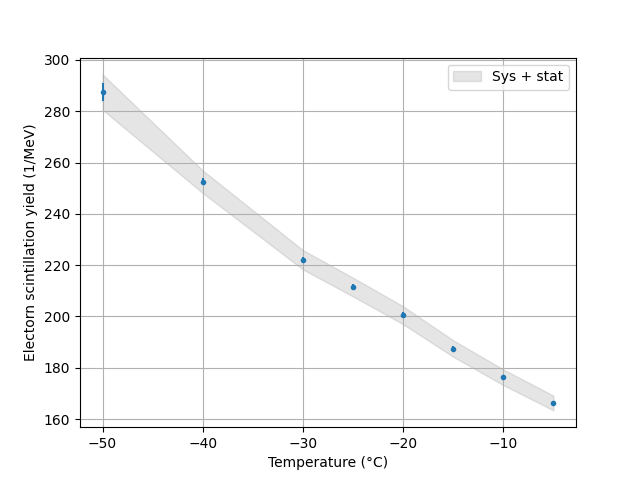

In [16]:
#Include geometry sys uncertainty 
temperatures = np.array(list(measured_data.keys()))
yields = np.array([measured_data[temp].calculated_yield.nominal_value for temp in temperatures])
yields_err = np.array([measured_data[temp].calculated_yield.std_dev for temp in temperatures])
sys_err = np.array([measured_data[temp].yield_systematic_error for temp in temperatures])
sys_err = np.sqrt(sys_err*sys_err + yields_err*yields_err + yields*yields*systematic_relative*systematic_relative)
plt.figure()
# Plotting
plt.errorbar(temperatures, yields, yerr=yields_err, fmt='.')
plt.fill_between(temperatures, yields - sys_err, yields + sys_err, color='gray', alpha=0.2, label='Sys + stat')

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Electorn scintillation yield (1/MeV)')
plt.grid()
plt.legend()

In [17]:
np.savetxt("okamoto_electron_yield_01umStep.dat", np.array([temperatures, yields, yields_err, sys_err]).T,header=("Temperature \t electron_yield(1/Mev) \t yield_error_statistical \t yield_error_sys+statistical"))

## Alpha Yield


With the electron yield determined, we now analyze the alpha data. Using a small simulation step (0.1 µm), alpha particles release delta electrons, making it essential to know the electron yield before calculating the alpha yield.

We first establish the linear relationship for detected photons produced by electrons in dependence of electron yield: $N_e = y_e\cdot E_{e,deposited} + C$ assuming the alpha yield is zero. Next, we reverse the process by setting  $y_e=0$ and determining the relationship for detected photons produced by alpha particles: $N_a = y_a\cdot E_{a,deposited} + C$.
Finally, we combine these relationships to fit the data. Since $N_e$ and $N_a$ are independent and $y_e$ is already known, it is not necessary to simulate combinations of $y_e$ and $y_a$.

In [25]:
N_simulated = 100000
yields_e = np.arange(175,450,25)
yields_a = np.arange(10,110,10)

In [ ]:
    
for yield_e in tqdm(yields_e):
    yield_a = 0
    os.system(f"./OMSim_scintillation_yield --QE_file qe_PMT373.txt --threads 31 -n {N_simulated} --detector_type 1 --yield_alphas {yield_a} --yield_electrons {yield_e} --output_file data_alpha_yield/01um/{yield_a}_{yield_e}")

for yield_a in tqdm(yields_a):
    yield_e = 0
    os.system(f"./OMSim_scintillation_yield --QE_file qe_PMT373.txt --threads 31 -n {N_simulated} --detector_type 1 --yield_alphas {yield_a} --yield_electrons {yield_e} --output_file data_alpha_yield/01um/{yield_a}_{yield_e}")


In [30]:
analysed_data_e = {}
for yield_e in tqdm(yields_e):
    yield_a = 0
    analysed_data_e[yield_e] = SimulationData(*np.loadtxt(f"data_alpha_yield/01um/{yield_a}_{yield_e}_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    analysed_data_e[yield_e].process_data(N_simulated)

  0%|          | 0/11 [00:00<?, ?it/s]

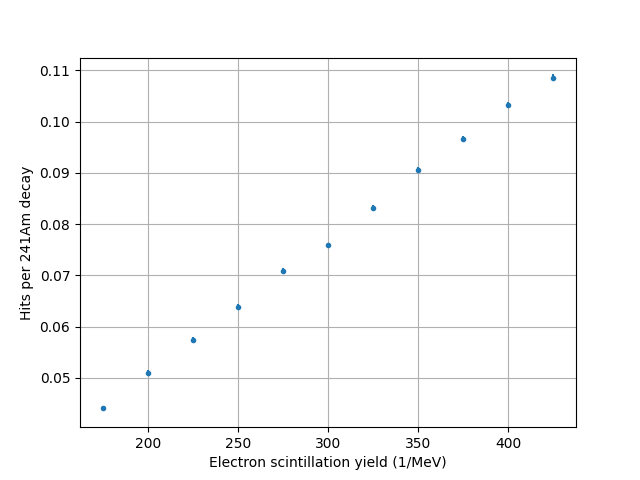

In [31]:
ufloat_values = [analysed_data_e[yield_val].hits_per_decay(0.25) for yield_val in yields_e]

yields = np.array(yields_e)
ufloat_values = np.array(ufloat_values)

plt.figure()
plt.errorbar(yields, [val.n for val in ufloat_values], yerr=[val.s for val in ufloat_values], fmt='.')
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.ylabel('Hits per 241Am decay')
plt.grid()
plt.show()

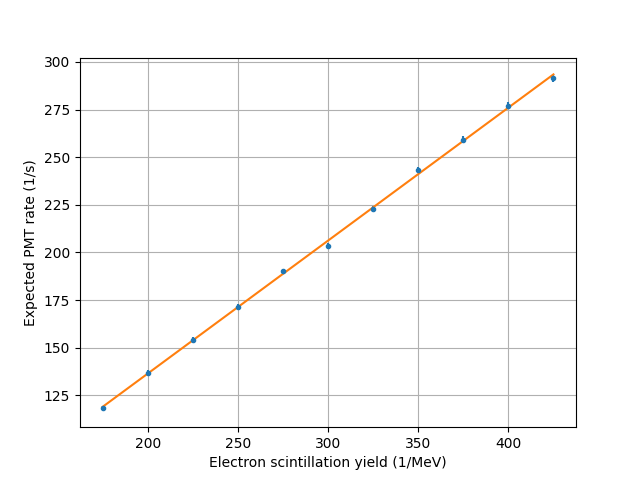

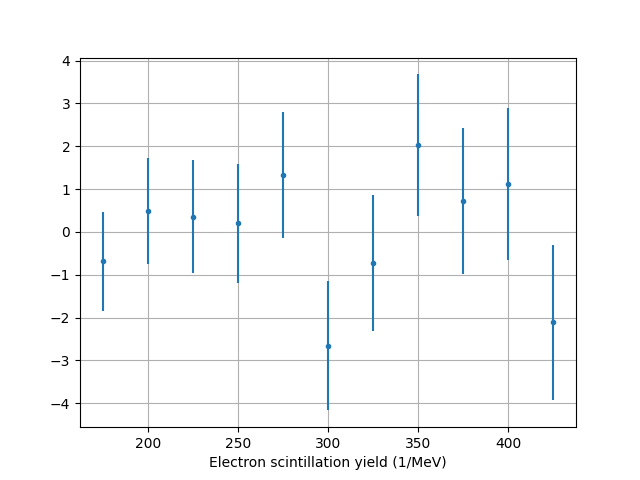

In [32]:
def lin(x,a,b):
    return x*a+b

AM241_activity = ufloat(2684, 82) 
pmt_rate = np.array(ufloat_values)*AM241_activity.n

popt,pcov = curve_fit(lin,yields, [val.n for val in pmt_rate], sigma=[val.s for val in pmt_rate], absolute_sigma=1 )
sim_slope_e, sim_const_e = uncertainties.correlated_values(popt, pcov)

plt.figure()
plt.errorbar(yields, [val.n for val in pmt_rate], yerr=[val.s for val in pmt_rate], fmt='.')
plt.plot(yields, lin(yields, *popt))
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.ylabel('Expected PMT rate (1/s)')
plt.grid()
plt.show()

plt.figure()
plt.errorbar(yields, np.array([val.n for val in pmt_rate])-lin(yields, *popt), yerr=[val.s for val in pmt_rate], fmt='.')
plt.xlabel('Electron scintillation yield (1/MeV)')
plt.grid()
plt.show()

In [33]:
analysed_data_a = {}
for yield_a in tqdm(yields_a):
    yield_e = 0
    analysed_data_a[yield_a] = SimulationData(*np.loadtxt(f"data_alpha_yield/01um/{yield_a}_{yield_e}_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    analysed_data_a[yield_a].process_data(N_simulated)

  0%|          | 0/10 [00:00<?, ?it/s]

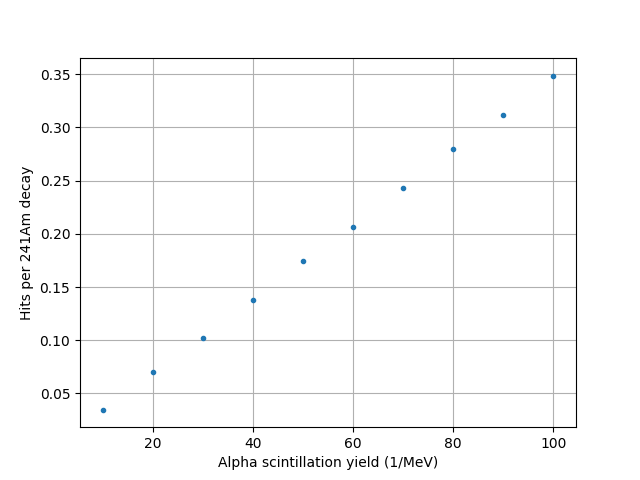

In [34]:
yields = np.array(yields_a)
ufloat_values = [analysed_data_a[yield_val].hits_per_decay(0.25) for yield_val in yields]

ufloat_values = np.array(ufloat_values)

plt.figure()
plt.errorbar(yields, [val.n for val in ufloat_values], yerr=[val.s for val in ufloat_values], fmt='.')
plt.xlabel('Alpha scintillation yield (1/MeV)')
plt.ylabel('Hits per 241Am decay')
plt.grid()
plt.show()

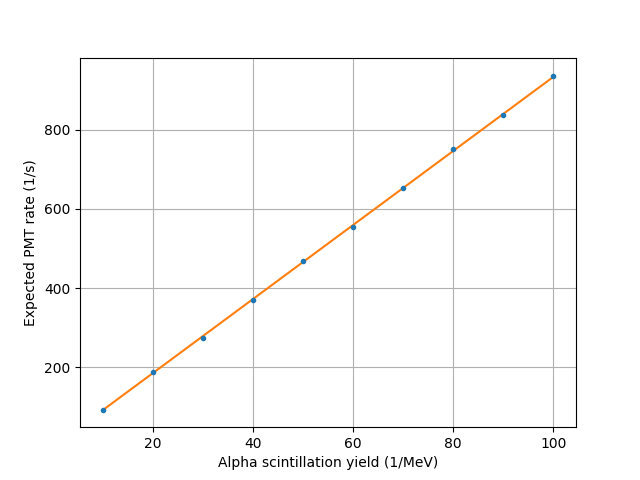

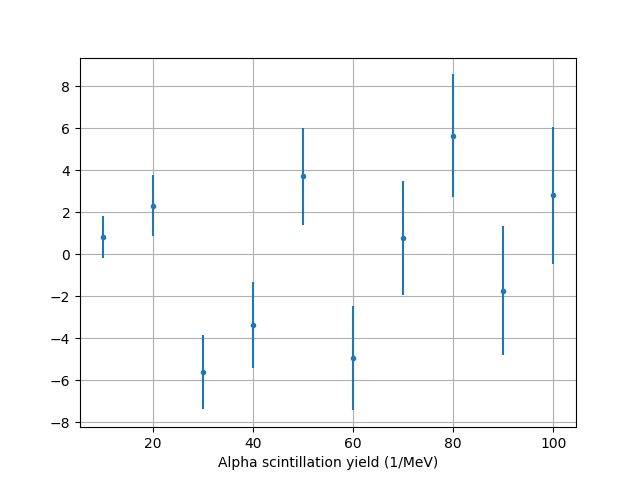

In [35]:
def lin(x,a,b):
    return x*a+b

AM241_activity = ufloat(2684, 82) 
pmt_rate = np.array(ufloat_values)*AM241_activity.n

popt,pcov = curve_fit(lin,yields, [val.n for val in pmt_rate], sigma=[val.s for val in pmt_rate], absolute_sigma=1 )
sim_slope_a, sim_const_a = uncertainties.correlated_values(popt, pcov)

plt.figure()
plt.errorbar(yields, [val.n for val in pmt_rate], yerr=[val.s for val in pmt_rate], fmt='.')
plt.plot(yields, lin(yields, *popt))
plt.xlabel('Alpha scintillation yield (1/MeV)')
plt.ylabel('Expected PMT rate (1/s)')
plt.grid()
plt.show()

plt.figure()
plt.errorbar(yields, np.array([val.n for val in pmt_rate])-lin(yields, *popt), yerr=[val.s for val in pmt_rate], fmt='.')
plt.xlabel('Alpha scintillation yield (1/MeV)')
plt.grid()
plt.show()


In [36]:
def get_electron_yield_at_temperature(temperature, fname = "okamoto_electron_yield_01umStep.dat"):
    temperatures, yields, yields_err, sys_err = np.loadtxt(fname, unpack=1)
    return interp1d(temperatures, yields)(temperature), interp1d(temperatures, sys_err)(temperature)

In [37]:
def get_yield(obj, rates):
    popt,pcov = curve_fit(lin,yields, [val.n for val in rates], sigma=[val.s for val in rates], absolute_sigma=0 )
    sim_slope, sim_const = uncertainties.correlated_values(popt, pcov)
    e_yield = (obj.rate-sim_const)/sim_slope
    #print(sim_const)
    return e_yield

def get_yield_with_systematics(obj: Measurement, data):
    electron_yield, sys_electron_yield = get_electron_yield_at_temperature(obj.temperature)
    rate_from_electrons = sim_slope_e*electron_yield+sim_const_e
    baseline_rates = [rate_from_electrons+AM241_activity.n*data[yield_val].hits_per_decay(obj.threshold.n) for yield_val in yields_a]
    baseline_yield = get_yield(obj, baseline_rates)
    
    print(f"Yield: {baseline_yield}, temperature {obj.temperature} rate electrons {rate_from_electrons}, electron yield {electron_yield}")
    #Sys uncertainty from threshold and electron yield systematics
    yield_sys = []
    for pe_threshold in np.random.normal(obj.threshold.n, obj.threshold.s, 100):
        #sampled_e_yield = np.random.normal(electron_yield, sys_electron_yield, 1)[0]
        #rate_from_electrons = sim_slope_e*electron_yield+sim_const_e
        rates = [rate_from_electrons+AM241_activity*data[yield_val].hits_per_decay(pe_threshold) for yield_val in yields_a]
        yield_sys.append(get_yield(obj, rates).n)
        
    sys_pe = np.std(yield_sys)
        
    #Sys uncertainty from source activity
    rates = [AM241_activity*data[yield_val].hits_per_decay(obj.threshold.n) for yield_val in yields_a]
    sys_activity_yield = get_yield(obj, rates).s
    
    print(f"Systematic error from source activity {sys_activity_yield} and PE threshold {sys_pe} (1/MeV)")
    
    return baseline_yield, np.sqrt(sys_activity_yield**2+sys_pe**2)



In [38]:
measured_data = {}        
with open("analysed_data_025PEcut_Okamot_Am241_with_sample_nearer_corrected.dat", "r") as f:
    for line in f:
        if "#" in line:
            continue
        temperature, _, _, rate, rate_err, _ = np.array(line.split()).astype("float")
        measured_data[temperature] = Measurement(ufloat(rate, rate_err), ufloat(rate, rate_err), temperature, ufloat(0.25, 0.01))
with open("analysed_data_025PEcut_Okamot_Am241_background_corrected.dat", "r") as f:
    for line in f:
        if "#" in line:
            continue
        temperature, _, _, rate, rate_err, _ = np.array(line.split()).astype("float")
        if temperature in measured_data:
            measured_data[temperature].rate_background= ufloat(rate, rate_err)
        
print(measured_data)

{np.float64(-50.0): Measurement(rate_sample=1291.2897520392578+/-2.3844196021503294, rate_background=71.59211960726017+/-12.495719850044274, temperature=np.float64(-50.0), threshold=0.25+/-0.01), np.float64(-40.0): Measurement(rate_sample=1216.3016581604966+/-2.723660585157294, rate_background=59.117553547172555+/-10.227305826921464, temperature=np.float64(-40.0), threshold=0.25+/-0.01), np.float64(-30.0): Measurement(rate_sample=1123.6162576498066+/-4.081455605046697, rate_background=55.99986671329307+/-6.463721356660603, temperature=np.float64(-30.0), threshold=0.25+/-0.01), np.float64(-25.0): Measurement(rate_sample=1069.6498509444336+/-3.4388986434537765, rate_background=49.00311609036533+/-11.07169299090185, temperature=np.float64(-25.0), threshold=0.25+/-0.01), np.float64(-20.0): Measurement(rate_sample=1036.0302427889335+/-2.560811442007705, rate_background=47.827052709214364+/-8.181224953496228, temperature=np.float64(-20.0), threshold=0.25+/-0.01), np.float64(-15.0): Measureme

In [39]:
for key, obj in measured_data.items():
    e_yields, u_sys = get_yield_with_systematics(obj, analysed_data_a)
    obj.calculated_yield = e_yields
    obj.yield_systematic_error = u_sys

Yield: 109.5+/-1.4, temperature -50.0 rate electrons 197.4+/-0.4, electron yield 287.46612434492255
Systematic error from source activity 1.4744970498671506 and PE threshold 0.12580794321949537 (1/MeV)
Yield: 105.5+/-1.2, temperature -40.0 rate electrons 173.0+/-0.5, electron yield 252.52620546317783
Systematic error from source activity 1.251182831935912 and PE threshold 0.12619864447667709 (1/MeV)
Yield: 98.1+/-0.9, temperature -30.0 rate electrons 151.8+/-0.5, electron yield 222.09793044914073
Systematic error from source activity 0.9496867522161148 and PE threshold 0.11375499648483738 (1/MeV)
Yield: 93.9+/-1.3, temperature -25.0 rate electrons 144.4+/-0.6, electron yield 211.46312253870914
Systematic error from source activity 1.324064918974959 and PE threshold 0.09964820737204062 (1/MeV)
Yield: 91.3+/-1.0, temperature -20.0 rate electrons 136.7+/-0.6, electron yield 200.46560468107378
Systematic error from source activity 1.0183997966301193 and PE threshold 0.0935099699269825 (1/M

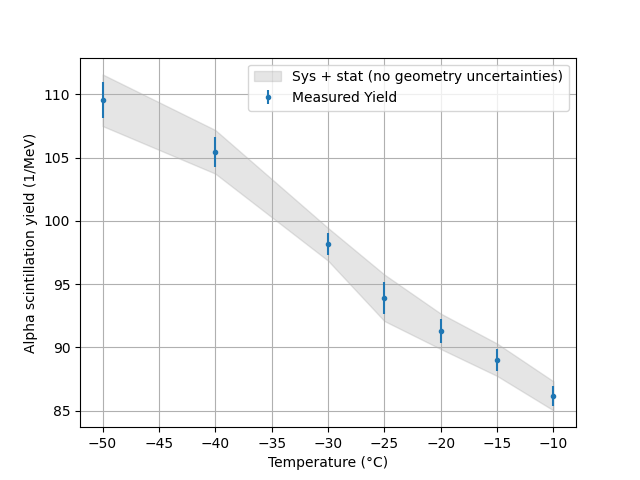

In [40]:
temperatures = np.array(list(measured_data.keys()))
yields_ = np.array([measured_data[temp].calculated_yield.nominal_value for temp in temperatures])
yields_err = np.array([measured_data[temp].calculated_yield.std_dev for temp in temperatures])
sys_err = np.array([measured_data[temp].yield_systematic_error for temp in temperatures])
sys_err = np.sqrt(sys_err*sys_err + yields_err*yields_err)
plt.figure()
# Plotting
plt.errorbar(temperatures, yields_, yerr=yields_err, fmt='.', label='Measured Yield')
plt.fill_between(temperatures, yields_ - sys_err, yields_ + sys_err, color='gray', alpha=0.2, label='Sys + stat (no geometry uncertainties)')

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Alpha scintillation yield (1/MeV)')
plt.grid()
plt.legend()


In [ ]:
average_yield = np.mean(yields_)
average_yield_e = 200
N_simulated = 50000
hits_per_decay = []
for n in tqdm(range(200)):
    os.system(f"./OMSim_scintillation_yield --QE_file qe_PMT373.txt --threads 31 -n {N_simulated} --detector_type 1 --yield_alphas {average_yield} --yield_electrons {average_yield_e} --output_file tmp --systematics")
    tmp = SimulationData(*np.loadtxt(f"tmp_hits.dat", unpack=1, usecols=(0,1,3,7,8,9)))
    tmp.process_data(N_simulated)
    hits_per_decay.append(tmp.hits_per_decay())
    os.system("rm -rf tmp_*.dat")
    os.system("rm -rf tmp_*.json")

In [22]:
hitrate = [val.n for val in hits_per_decay]
hitratest = [val.s for val in hits_per_decay]
print(np.std(hitrate)*100/np.mean(hitrate), np.mean(hitratest)*100/np.mean(hitrate))
#Substract statistical uncertainty from systematics
rel_sys_stat = np.std(hitrate)/np.mean(hitrate)
rel_stat = np.mean(hitratest)/np.mean(hitrate)
systematic_relative = np.sqrt(rel_sys_stat**2 - rel_stat**2)
print(f"Relative systematic uncertainty from geometry errors in setup: {round(systematic_relative*100,3)} %")

2.0131968657861963 0.4519534015263408
Relative systematic uncertainty from geometry errors in setup: 1.962 %


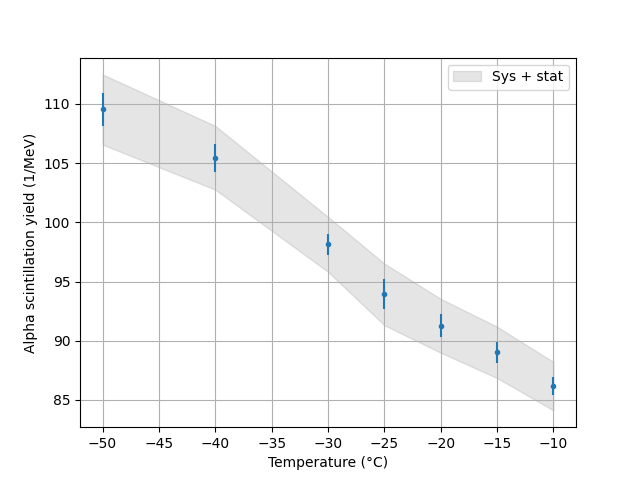

In [23]:
systematic_relative = np.sqrt(rel_sys_stat**2 - rel_stat**2)
#Include geometry sys uncertainty 
temperatures = np.array(list(measured_data.keys()))
yields = np.array([measured_data[temp].calculated_yield.nominal_value for temp in temperatures])
yields_err = np.array([measured_data[temp].calculated_yield.std_dev for temp in temperatures])
sys_err = np.array([measured_data[temp].yield_systematic_error for temp in temperatures])
sys_err = np.sqrt(sys_err*sys_err + yields_err*yields_err + yields*yields*systematic_relative*systematic_relative)
plt.figure()
# Plotting
plt.errorbar(temperatures, yields, yerr=yields_err, fmt='.')
plt.fill_between(temperatures, yields - sys_err, yields + sys_err, color='gray', alpha=0.2, label='Sys + stat')

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Alpha scintillation yield (1/MeV)')
plt.grid()
plt.legend()

In [24]:
np.savetxt("okamoto_alpha_yield_01umStep.dat", np.array([temperatures, yields, yields_err, sys_err]).T,header=("Temperature \t alpha_yield(1/Mev) \t yield_error_statistical \t yield_error_sys+statistical"))

## Generate new file

In [46]:
import json

In [60]:
with open("../common/data/scintillation/Scint_Okamoto.dat", "r") as f:
    data = json.load(f)

In [61]:
t, y = np.loadtxt("okamoto_alpha_yield_01umStep.dat", unpack=1, usecols=(0,1))
data["jYieldAlpha"] = y.tolist()
data["jYieldAlphaTemperature"] = t.tolist()

t, y = np.loadtxt("okamoto_electron_yield_01umStep.dat", unpack=1, usecols=(0,1))
data["jYieldElectron"] = y.tolist()
data["jYieldElectronTemperature"] = t.tolist()

In [63]:
data

{'jName': 'Scintillation_Okamoto',
 'jMaterialName': 'RiAbs_Glass_Okamoto_DOUMEKI',
 'Lifetimes': {'-50': {'jTimes': [0.0004,
    9.4e-08,
    3.766654248940662e-05,
    5.907016080330999e-06,
    1.2749085046116029e-06,
    2.038650082181329e-07,
    0.0002566081544974529,
    4e-07],
   'jAmplitudes': [0.0,
    0.0,
    0.2731771739991939,
    0.18233871357186893,
    0.125219280122605,
    0.14246337900894188,
    0.2768014532973902,
    0.0]},
  '-40': {'jTimes': [0.0004,
    9.4e-08,
    3.428387527008619e-05,
    9.197290247669281e-06,
    2.1100234653397894e-06,
    2.1814310407528903e-07,
    0.00021428465752761037,
    4e-07],
   'jAmplitudes': [0.0,
    0.0,
    0.24707087303510628,
    0.13316897790684762,
    0.1961412192444341,
    0.16593487585354452,
    0.2576840539600674,
    0.0]},
  '-30': {'jTimes': [0.0004,
    9.4e-08,
    3.687605944634612e-05,
    7.5001949341906724e-06,
    1.7920032604024966e-06,
    1.8146264178509333e-07,
    0.00024129392977600484,
    4e-0

In [65]:
with open("Scint_Okamoto.dat", "w") as outfile: 
    json.dump(data, outfile, indent=1)